In [6]:
from typing import TypedDict, Annotated, Optional
from langgraph.graph import add_messages, StateGraph, END
from langchain.chat_models import init_chat_model
from dotenv import load_dotenv
from langchain_tavily import TavilySearch
from langgraph.checkpoint.memory import MemorySaver
from uuid import uuid4

In [ ]:
load_dotenv()

True

In [32]:
model = init_chat_model("groq:moonshotai/kimi-k2-instruct-0905")
model.invoke("Tell me a joke about cats.")

AIMessage(content='Why did the cat sit on the computer?\n\nBecause it wanted to keep an eye on the mouse.', additional_kwargs={}, response_metadata={'token_usage': {'completion_tokens': 21, 'prompt_tokens': 33, 'total_tokens': 54, 'completion_time': 0.040066165, 'completion_tokens_details': None, 'prompt_time': 0.014820266, 'prompt_tokens_details': None, 'queue_time': 0.281597171, 'total_time': 0.054886431}, 'model_name': 'moonshotai/kimi-k2-instruct-0905', 'system_fingerprint': 'fp_3312304636', 'service_tier': 'on_demand', 'finish_reason': 'stop', 'logprobs': None, 'model_provider': 'groq'}, id='lc_run--019c28af-89d9-7951-8118-68a2efea70ea-0', tool_calls=[], invalid_tool_calls=[], usage_metadata={'input_tokens': 33, 'output_tokens': 21, 'total_tokens': 54})

In [33]:
search_tool = TavilySearch(max_results=4)
search_tool.invoke("Latest news on Reagan Foxx")

{'query': 'Latest news on Reagan Foxx',
 'follow_up_questions': None,
 'answer': None,
 'images': [],
 'results': [{'url': 'https://www.instagram.com/popular/Reagan-Foxx-latest-news/',
   'title': 'Reagan Foxx Latest News - Instagram',
   'content': "Foxx chaired a House Rules Committee meeting on Tuesday night (11 November) ahead of the lower chamber's vote to reopen federal government.",
   'score': 0.8003337,
   'raw_content': None},
  {'url': 'https://www.xbiz.com/p/reagan-foxx',
   'title': 'Reagan Foxx - XBIZ.com',
   'content': 'Reagan Foxx Returns to Brazzers. 2023 XMAs MILF Performer of the Year Reagan Foxx stars with Small Hands and Damon Dice in the latest release from Brazzers,',
   'score': 0.7018975,
   'raw_content': None},
  {'url': 'https://www.imdb.com/name/nm8624444/news/',
   'title': 'Reagan Foxx - News - IMDb',
   'content': "Reagan Foxx - It looks like we don't have any news for this person yet. Be the first to contribute.",
   'score': 0.63152665,
   'raw_conten

In [34]:
tools = [search_tool]
llm_with_tools = model.bind_tools(tools)

response = llm_with_tools.invoke("What is the current weather in Kolkata?")


In [35]:
response

AIMessage(content="I'll search for the current weather information in Kolkata for you.", additional_kwargs={'tool_calls': [{'id': 'functions.tavily_search:0', 'function': {'arguments': '{"query":"current weather in Kolkata today temperature conditions"}', 'name': 'tavily_search'}, 'type': 'function'}]}, response_metadata={'token_usage': {'completion_tokens': 37, 'prompt_tokens': 1585, 'total_tokens': 1622, 'completion_time': 0.138628517, 'completion_tokens_details': None, 'prompt_time': 0.473458757, 'prompt_tokens_details': None, 'queue_time': 0.292585798, 'total_time': 0.612087274}, 'model_name': 'moonshotai/kimi-k2-instruct-0905', 'system_fingerprint': 'fp_05df423bab', 'service_tier': 'on_demand', 'finish_reason': 'tool_calls', 'logprobs': None, 'model_provider': 'groq'}, id='lc_run--019c28af-9359-7fc1-a44e-6e6e0c027d28-0', tool_calls=[{'name': 'tavily_search', 'args': {'query': 'current weather in Kolkata today temperature conditions'}, 'id': 'functions.tavily_search:0', 'type': 'to

In [36]:
memory = MemorySaver()

In [37]:
from langchain_core.messages import AIMessage, HumanMessage, ToolMessage

class State(TypedDict):
    messages: Annotated[list, add_messages]

async def model(state: State):
    result = await llm_with_tools.ainvoke(state["messages"])
    return {
        "messages": [result], 
    }

async def tools_router(state: State):
    last_message = state["messages"][-1]

    if(hasattr(last_message, "tool_calls") and len(last_message.tool_calls) > 0):
        return "tool_node"
    else: 
        return END
    
async def tool_node(state):
    """Custom tool node that handles tool calls from the LLM."""
    # Get the tool calls from the last message
    tool_calls = state["messages"][-1].tool_calls
    
    # Initialize list to store tool messages
    tool_messages = []
    
    # Process each tool call
    for tool_call in tool_calls:
        tool_name = tool_call["name"]
        tool_args = tool_call["args"]
        tool_id = tool_call["id"]
        
        # Handle the search tool
        if tool_name == "tavily_search_results_json":
            # Execute the search tool with the provided arguments
            search_results = await search_tool.ainvoke(tool_args)
            
            # Create a ToolMessage for this result
            tool_message = ToolMessage(
                content=str(search_results),
                tool_call_id=tool_id,
                name=tool_name
            )
            
            tool_messages.append(tool_message)
    
    # Add the tool messages to the state
    return {"messages": tool_messages}

graph_builder = StateGraph(State)

graph_builder.add_node("model", model)
graph_builder.add_node("tool_node", tool_node)
graph_builder.set_entry_point("model")

graph_builder.add_conditional_edges("model", tools_router,
                                    {
                                            "tool_node": "tool_node",  # Map "tool_node" string to actual node
                                            END: END                    # Map END to END
                                    })
graph_builder.add_edge("tool_node", "model")

graph = graph_builder.compile(checkpointer=memory)

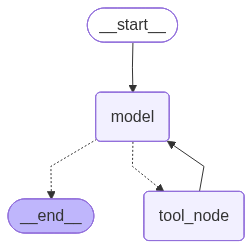

In [38]:
from IPython.display import Image, display
from langchain_core.runnables.graph import MermaidDrawMethod

display(
    Image(
        graph.get_graph().draw_mermaid_png(
            draw_method=MermaidDrawMethod.API
        )
    )
)

In [46]:
config = {
    "configurable": {
        "thread_id": 6
    }
}

response = await graph.ainvoke({
    "messages": [HumanMessage(content="when is the next SpaceX launch" )], 
}, config=config)

response

{'messages': [HumanMessage(content='How is the weather in Kolkata', additional_kwargs={}, response_metadata={}, id='0b6a746a-c35a-4823-8a13-25020fdc09aa'),
  AIMessage(content="I'll search for current weather information about Kolkata for you.", additional_kwargs={'tool_calls': [{'id': 'functions.tavily_search:0', 'function': {'arguments': '{"query":"Kolkata weather today current conditions temperature"}', 'name': 'tavily_search'}, 'type': 'function'}]}, response_metadata={'token_usage': {'completion_tokens': 36, 'prompt_tokens': 1583, 'total_tokens': 1619, 'completion_time': 0.138855005, 'completion_tokens_details': None, 'prompt_time': 0.017551235, 'prompt_tokens_details': {'cached_tokens': 1536}, 'queue_time': 0.282895152, 'total_time': 0.15640624}, 'model_name': 'moonshotai/kimi-k2-instruct-0905', 'system_fingerprint': 'fp_3312304636', 'service_tier': 'on_demand', 'finish_reason': 'tool_calls', 'logprobs': None, 'model_provider': 'groq'}, id='lc_run--019c28b0-5328-7693-aefe-de5307d

In [52]:
config = {
    "configurable": {
        "thread_id": 10
    }
}

events = graph.astream_events({
    "messages": [HumanMessage(content="When is ronaldos bday" )], 
}, config=config, version="v2")

async for event in events:
    print(event)

# async for event in events:
#      if event["event"] == "on_chat_model_stream":
#           print(event["data"]["chunk"].content, end='', flush=True)

{'event': 'on_chain_start', 'data': {'input': {'messages': [HumanMessage(content='When is ronaldos bday', additional_kwargs={}, response_metadata={})]}}, 'name': 'LangGraph', 'tags': [], 'run_id': '019c2927-0a8a-7693-921b-e472e6c5d6a7', 'metadata': {'thread_id': 10}, 'parent_ids': []}
{'event': 'on_chain_start', 'data': {'input': {'messages': [HumanMessage(content='When is ronaldos bday', additional_kwargs={}, response_metadata={}, id='fd7220de-3e24-48eb-bb0e-e1ec44bffe98')]}}, 'name': 'model', 'tags': ['graph:step:1'], 'run_id': '019c2927-0a94-78c2-927c-36163d1bce26', 'metadata': {'thread_id': 10, 'langgraph_step': 1, 'langgraph_node': 'model', 'langgraph_triggers': ('branch:to:model',), 'langgraph_path': ('__pregel_pull', 'model'), 'langgraph_checkpoint_ns': 'model:35b1749b-e5fa-5643-0b73-71a741dc2fd6'}, 'parent_ids': ['019c2927-0a8a-7693-921b-e472e6c5d6a7']}
{'event': 'on_chat_model_start', 'data': {'input': {'messages': [[HumanMessage(content='When is ronaldos bday', additional_kwa